In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  8 13:34:59 2019

@author: etellez
"""

#!/usr/bin/env python
"""Test UNet and create a Kaggle submission."""
__author__ = 'Erdene-Ochir Tuguldur, Yuan Xu'

import time
import argparse
from tqdm import tqdm
import cv2

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import models
from torchvision.transforms import *
from skimage.io import imread
from datasets import *
from transforms import *
import skimage 
from utils import rlenc, rlenc_np, FasterRle, gzip_save
import scipy.misc
import imageio
from PIL import Image
import numpy
from skimage.filters import threshold_otsu
from utils.metrics import calc_metric
import os.path as path


In [7]:


def predict(model, batch,  use_gpu):
    image_ids, inputs = batch['image_id'], batch['input']
    image_ids, inputs, targets = batch['image_id'], batch['input'], batch['mask']
    #logit, logit_pixel, logit_image = model(inputs)

    if use_gpu:
        inputs = inputs.cuda()
    print (inputs.dtype)
    outputs, _, _ = model(inputs)
    print("salvar a archivos demora bastante ")
    indiceBatch = 0  ;
    mascaras=[]
           
    targets_numpy = targets.cpu().numpy()
    squeeze = torch.squeeze(outputs)
    probs_numpy =squeeze .cpu().detach().numpy()
    threshold  = threshold_otsu(probs_numpy)
    predictions_numpy = probs_numpy >0.5  # predictions.cpu().numpy()
    metric_array = calc_metric(targets_numpy, predictions_numpy, type='iou', size_average=False)
    
    metric_array2 = calc_metric(targets_numpy, predictions_numpy, type='pixel_accuracy', size_average=False)

    metric = metric_array2.mean()

    print(str(metric_array))
    for  i in image_ids:
        temp = outputs[indiceBatch][0].numpy()
        temp = temp.astype(numpy.float32)
        s = threshold_otsu(temp)
        probs =temp>=0.5
        probs =probs.astype(numpy.float32)
        print (str(probs))
        print(str(outputs.shape))
        imageio.imwrite('outfile'+str(i)+'.png', temp)
        imageio.imwrite('outfileSi'+str(i)+'.png', probs)
        indiceBatch = indiceBatch+1
        mascaras.append(probs)
    return outputs,mascaras,metric_array2


In [8]:

 

def test(arr):
    test_transform = Compose([PrepareImageAndMask(),
                              HWCtoCHW()])
    arrParaTest=arr
    test_dataset = SaltIdentification(mode='test', transform=test_transform, preload=False ,pruebas = arrParaTest)
    test_dataloader = DataLoader(test_dataset, batch_size=len(arr))

 #   model.eval()
    torch.set_grad_enabled(False)

    pbar = tqdm(test_dataloader, unit="images", unit_scale=test_dataloader.batch_size, disable=None)

    for batch in pbar:
        print("al momento de enviar"+str(batch['input'].dtype))
        out,mascaras,metric_array=predict(model, batch, use_gpu=use_gpu)
        return out,mascaras,metric_array


In [9]:
def mostrarInfo(lista, idImagen,out,mascaras,metric):
    matplotlib.rcParams['font.size'] = 9
    
    try:
        image = imread("./mytrain/train_"+str(lista[idImagen])+".jpg")
    except :
        image = imread("./mytrain/train_"+str(lista[idImagen])+".tif")

    archivo = "./mytrain/train_"+str(lista[idImagen])+"_json/label.png"
    if path.exists(archivo):
        mask = imread(archivo, as_gray=True)
    else:
        mask = image
   
    mask = cv2.resize(mask,(128,128))
    mask = mask >0
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    ax1, ax2, ax3, ax4 = ax.ravel()
    
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(mascaras[idImagen], cmap=plt.cm.gray)
    ax2.set_title('resultado')
    ax2.axis('off')
    
    ax3.imshow(mask, cmap=plt.cm.gray)
    ax3.set_title('resultado Esperado')
    ax3.axis('off')
    
    
#    ax4.imshow(out[idImagen][0].numpy(), cmap=plt.cm.gray)
#    ax4.set_title('sin binarisar')
#    ax4.axis('off')
    
    comparacion =(mask +mascaras[idImagen])%2
    suma  =np.sum(comparacion)
    resultado = 1.0-suma /(128.0*128.0)
    print (resultado)
    ax4.imshow(comparacion, cmap=plt.cm.gray)
    ax4.set_title('sin binarisar')
    ax4.axis('off')
    
    plt.show()



use_gpu False
loading model...
load runs/fold2/models/1554327304169-last-model-unet_fold2_adamw_noam_bs6_lr8.0e-04_wd1.0e-04.pth


Load dataset test: 100%|██████████| 8/8 [00:00<00:00, 21606.20images/s]


al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de leeruint8
al momento de enviartorch.float32
torch.float32


e1 torch.Size([8, 128, 64, 64])
d2 torch.Size([8, 16, 64, 64])
d1 torch.Size([8, 16, 128, 128])


salvar a archivos demora bastante 
La rica Union16343 La rica Intersection15784
El rico resultado 0.9657957535336229
La rica Union16384 La rica Intersection16374
El rico resultado 0.9993896484375
La rica Union14259 La rica Intersection12536
El rico resultado 0.8791640367487201
La rica Union16216 La rica Intersection16163
El rico resultado 0.9967316230883079
La rica Union16384 La rica Intersection15893
El rico resultado 0.97003173828125
La rica Union15914 La rica Intersection15706
El rico resultado 0.9869297473922333
La rica Union10779 La rica Intersection10320
El rico resultado 0.9574172001113276
La rica Union16067 La rica Intersection15475
El rico resultado 0.9631542914047426
hakuna matata
llegue aqui
(8, 128, 128)
[15825. 16374. 14661. 16331. 15893. 16176. 15925. 15792.]
16384
[1.  1.  0.8 1.  1.  1.  1.  1. ]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
torch.Size([8, 1, 12

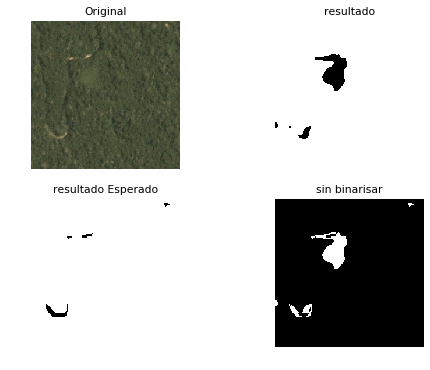

**********************************
1
0.9993896484375


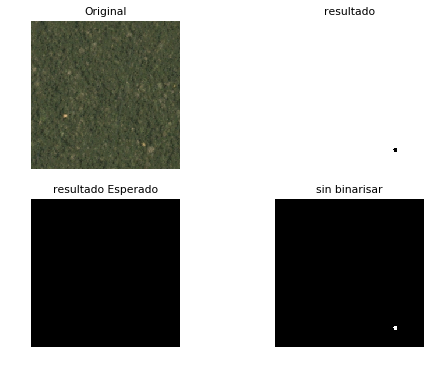

**********************************
2
0.89483642578125


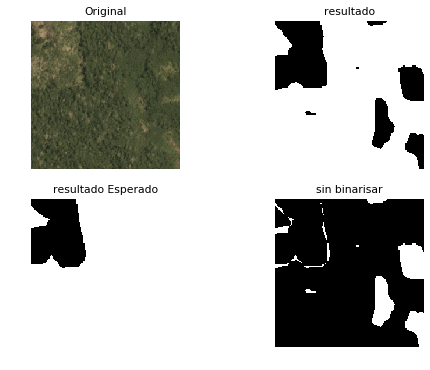

**********************************
3
0.99676513671875


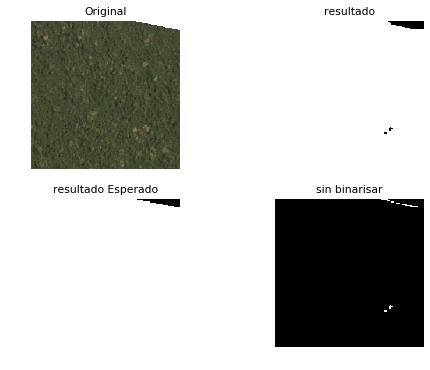

**********************************
4
0.97003173828125


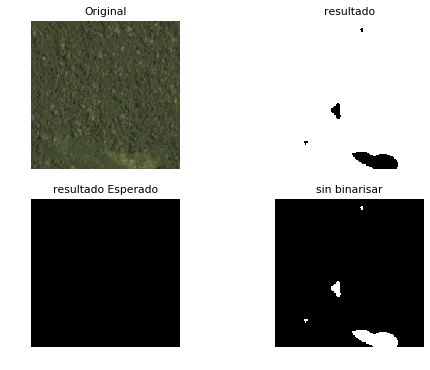

**********************************
5
0.9873046875


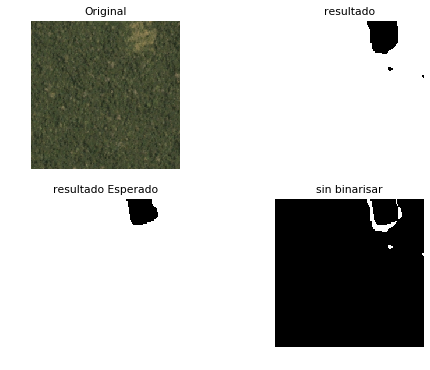

**********************************
6
0.97198486328125


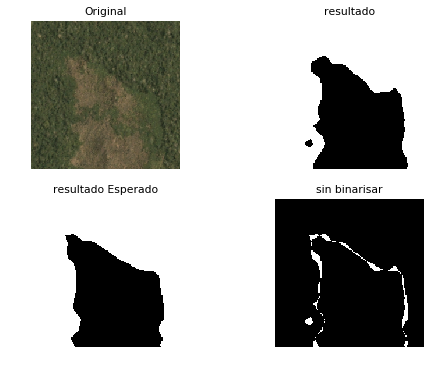

**********************************
7
0.9638671875


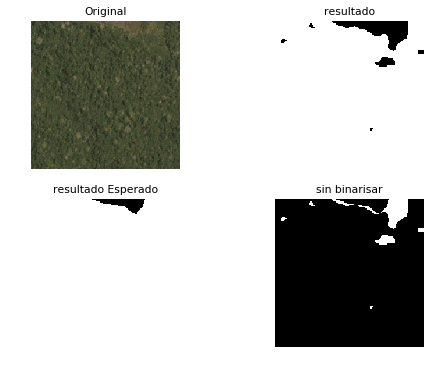

finished


In [10]:

if __name__ == '__main__':
   

    lista= [51371,51373,51597,51606,51607,51608,51609,51610]
    use_gpu = False
    print('use_gpu', use_gpu)

    print("loading model...")
    saved_checkpoint = torch.load("runs/fold2/checkpoints/last-checkpoint-fold2.pth")
    old_model = models.load(saved_checkpoint['model_file'])
    old_model = old_model.cpu()
    model = old_model.float()   
    since = time.time()
    out,mascaras,metric=test(lista)
    rx = 0 
    for i in range(len(lista)):
        print ("**********************************")
        print (str(rx))
        mostrarInfo(lista,i,out,mascaras,metric)
        rx = rx+1
    

    time_elapsed = time.time() - since
    time_str = 'total time elapsed: {:.0f}h {:.0f}m {:.0f}s '.format(time_elapsed // 3600, time_elapsed % 3600 // 60,
                                                                     time_elapsed % 60)
    print("finished")


In [12]:
print (metric)


[0.96588135 0.99938965 0.89483643 0.99676514 0.97003174 0.98730469
 0.97198486 0.96386719]
